#*Project Title*: **Online News Popularity Analysis and Prediction**

#### ***Importing libraries for analysis***

In [ ]:
## Import drive to pull dataset stored on google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Import libaries needed for analysis and prediction
!pip install prophet pyspark pandas

import os
import sys
import math
import numpy as np
import pandas as pd

## pyspark modules
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql.functions import isnan, when, count, col, lit, log, udf
from pyspark.sql.types import DoubleType

## data visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


### **Helper Functions**

We would be using PySpark for this project, needed libraries imported

In [ ]:

def init_spark():
    # Create a new SparkSession object with a specific app name and configuration options
    spark = SparkSession.builder.appName("OnlineNewsProject") \
                        .config("spark.some.config.option", "some-value") \
                        .config("spark.driver.memory", "10g") \
                        .getOrCreate()

    # Return the SparkSession object
    return spark

def read_input(filepath):
  spark = init_spark()
  spark_df = spark.read.csv(filepath, header=True, inferSchema=True)
  return spark_df

def drop_Columss(cols, dataset):
    # Drop the specified columns from the given dataset
    for i in cols:
        dataset = dataset.drop(i)
    return dataset


### **Data Exploration Functions**


In [ ]:
def safe_format(value, fmt_width):
    """Safely format the value, converting None to 'N/A'."""
    if value is None:
        return "N/A".ljust(fmt_width)
    else:
        return f"{value:<{fmt_width}}"

# Show the summary statistics of the dataset
def desribe_data(data_frame):
  #data_frame.printSchema()
  df_summary = data_frame.describe()

  summary_pd = df_summary.toPandas().set_index('summary').transpose()
  schema_info = [(field.name, field.dataType, field.nullable) for field in data_frame.schema.fields]
  schema_df = pd.DataFrame(schema_info, columns=['Feature', 'DataType', 'Nullable'])
  schema_df['DataType'] = schema_df['DataType'].astype(str)
  combined_df = summary_pd.merge(schema_df, left_index=True, right_on='Feature')

  final_columns = ['Feature', 'DataType', 'Nullable', 'count', 'mean', 'stddev', 'min', 'max']
  combined_df = combined_df[final_columns]

  combined_df.set_index('Feature', inplace=True)

  col_widths = {"Feature": 30, "DataType": 15, "Nullable": 10, "Count": 10, "Mean": 20, "Stddev": 20, "Min": 40, "Max": 40}

  header_format = "{:<{Feature}}{:<{DataType}}{:<{Nullable}}{:<{Count}}{:<{Mean}}{:<{Stddev}}{:<{Min}}{:<{Max}}"
  print(header_format.format("Feature", "Data Type", "Nullable", "Count", "Mean", "Stddev", "Min", "Max", **col_widths))

  print("-" * sum(col_widths.values()))

  for feature, row in combined_df.iterrows():
    formatted_row = "{feature}{data_type}{nullable}{count}{mean}{stddev}{min}{max}".format(
        #feature=safe_format(feature, col_widths["Feature"]),
        feature=safe_format(feature, col_widths["Feature"]),
        data_type=safe_format(row.get('DataType', "N/A"), col_widths["DataType"]),
        nullable=safe_format(row.get('Nullable', "N/A"), col_widths["Nullable"]),
        count=safe_format(row.get('count', "N/A"), col_widths["Count"]),
        mean=safe_format(row.get('mean', "N/A"), col_widths["Mean"]),
        stddev=safe_format(row.get('stddev', "N/A"), col_widths["Stddev"]),
        min=safe_format(row.get('min', "N/A"), col_widths["Min"]),
        max=safe_format(row.get('max', "N/A"), col_widths["Max"]))
    print(formatted_row)


# Show Missing values
def check_missing_data(data_frame):
  null_counts = data_frame.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_frame.columns])
  null_counts_collected = null_counts.collect()[0]
  print("Feature", "Null Count")
  for c in data_frame.columns:
    print(f"{c:30} {null_counts_collected[c]}")

def remove_spaces_cols(data_frame):
  '''cleaned_columns = [col("`" + c + "`").alias(c.strip()) for c in data_frame.columns]
  data_frame_cleaned = data_frame.select(*cleaned_columns)
  return data_frame_cleaned'''
  cleaned_columns = [col(c).alias(c.strip()) for c in data_frame.columns]
    # Select the cleaned columns from the DataFrame
  data_frame_cleaned = data_frame.select(*cleaned_columns)
  return data_frame_cleaned

## histogram View of target variable 'Shares'
def visualize_target_variable_histogram(data_frame):

    shares_pd = data_frame.select('shares').toPandas()['shares']
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(shares_pd, bins=50, color='orange', alpha=0.7, stat="density")
    sns.kdeplot(shares_pd, ax=ax, color='teal', linewidth=2)

    plt.title('Distribution of Shares')
    plt.xlabel('Shares')
    plt.ylabel('Frequency')
    plt.show()

  ## BoxPlot View
def visualize_target_variable_BoxPlot(data_frame):
    shares_pd = data_frame.select('shares').toPandas()['shares']
    plt.figure(figsize=(10, 6))
    shares_pd.plot(kind='box', vert=False)
    plt.title('Box Plot of Shares')
    plt.show()

def display_correlation(corr):
    plt.figure(figsize=(50, 50))
    sns.heatmap(corr, annot=True, yticklabels=corr.columns)
    plt.savefig('pearson_corr_heatmap.png', bbox_inches='tight')
    plt.show()

# Plot Spearman Correlation with All Variables
def plot_spearman_correlation_all(data_frame):
    pandas_df = data_frame.toPandas()
    spearman_corr = pandas_df.corr(method='spearman')
    display_correlation(spearman_corr)

# Plot Spearman Correlation with Target Variables
def plot_spearman_correlation_target(data_frame, target):
    df_corr = pd.DataFrame({'features': data_frame.columns})
    df_corr['spearman'] = [data_frame.stat.corr(c, target) for c in data_frame.columns]
    df_corr = df_corr.sort_values('spearman')
    plt.figure(figsize=(5, 0.20 * len(df_corr)))
    sns.barplot(data=df_corr, y='features', x='spearman', orient='h',palette='viridis')
    plt.title("Spearman correlation with 'shares' target variable")
    plt.show()
    return df_corr

# calculate the Variance Inflation Factor (VIF) to quantitatively assess multicollinearity.
def calculate_VIF(data_frame):
    numeric_types = ['int', 'double', 'float', 'long']
    df_features = [field.name for field in data_frame.schema.fields if field.dataType.simpleString() in numeric_types]

    data_frame_with_intercept = data_frame.withColumn('intercept', lit(1))

    # Select only the numeric features and the intercept
    numeric_features_with_intercept = ['intercept'] + df_features

    # Convert to Pandas DataFrame for VIF calculation
    df_numeric_pd = data_frame_with_intercept.select(numeric_features_with_intercept).toPandas()

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_numeric_pd.columns
    vif_data["VIF"] = [variance_inflation_factor(df_numeric_pd.values, i) for i in range(df_numeric_pd.shape[1])]

    return vif_data.sort_values(by="VIF")

# Plot pair plot to choose variables based on low correlation and VIF
def plot_pairplot(data_frame, selected_columns):
  sns.pairplot(data_frame[selected_columns])
  plt.show()

### **Perform Exploratory Data Analysis on the dataset**

In [ ]:
data_set = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
desribe_data(data_set)

Feature                       Data Type      Nullable  Count     Mean                Stddev              Min                                     Max                                     
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
url                           StringType()   1         39644     N/A                 N/A                 http://mashable.com/2013/01/07/amazon-instant-video-browser/http://mashable.com/2014/12/27/youtube-channels-2015/
 timedelta                    DoubleType()   1         39644     354.53047119362327  214.16376716976984  8.0                                     731.0                                   
 n_tokens_title               DoubleType()   1         39644     10.398748864897588  2.1140368083035366  2.0                                     23.0                                    
 n_tokens_content             DoubleT

In [ ]:
check_missing_data(data_set)

Feature Null Count
url                            0
 timedelta                     0
 n_tokens_title                0
 n_tokens_content              0
 n_unique_tokens               0
 n_non_stop_words              0
 n_non_stop_unique_tokens      0
 num_hrefs                     0
 num_self_hrefs                0
 num_imgs                      0
 num_videos                    0
 average_token_length          0
 num_keywords                  0
 data_channel_is_lifestyle     0
 data_channel_is_entertainment 0
 data_channel_is_bus           0
 data_channel_is_socmed        0
 data_channel_is_tech          0
 data_channel_is_world         0
 kw_min_min                    0
 kw_max_min                    0
 kw_avg_min                    0
 kw_min_max                    0
 kw_max_max                    0
 kw_avg_max                    0
 kw_min_avg                    0
 kw_max_avg                    0
 kw_avg_avg                    0
 self_reference_min_shares     0
 self_reference_max_shar

In [ ]:
## There is leading space in target column 'shares'
data_set = remove_spaces_cols(data_set)

In [ ]:
# Since our target column is 'share', check statistics for share
data_set.describe('shares').show()

+-------+------------------+
|summary|            shares|
+-------+------------------+
|  count|             39644|
|   mean|3395.3801836343455|
| stddev|11626.950748651721|
|    min|               1.0|
|    max|          843300.0|
+-------+------------------+



In [ ]:
## drop string URL column from analysis
data_set = drop_Columss(['url'],data_set)

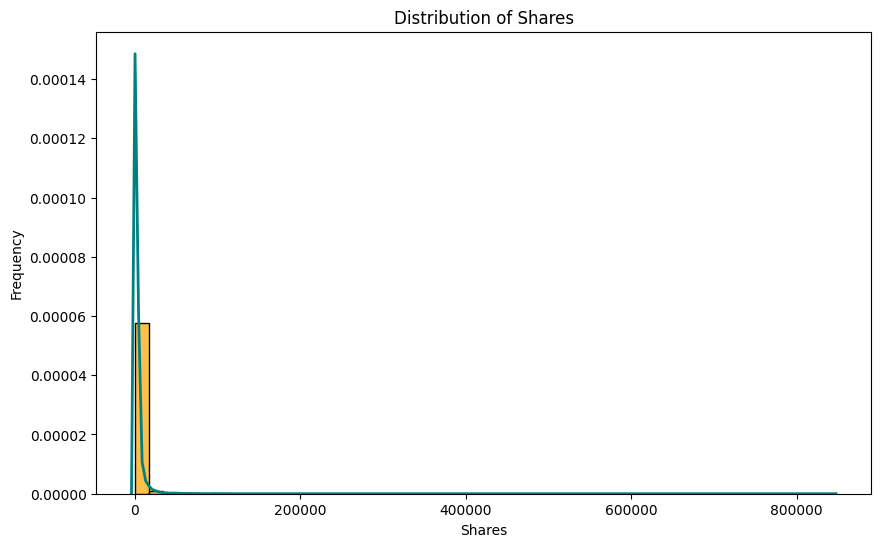

In [ ]:
visualize_target_variable_histogram(data_set)

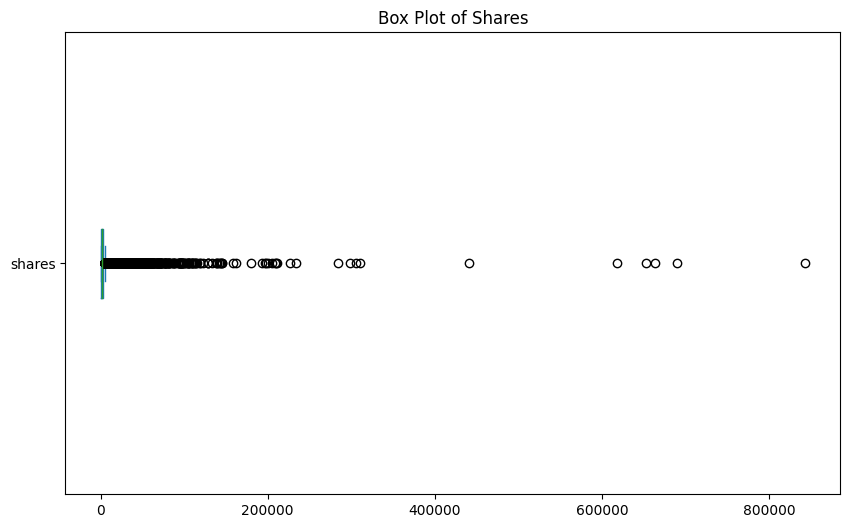

In [ ]:
visualize_target_variable_BoxPlot(data_set)

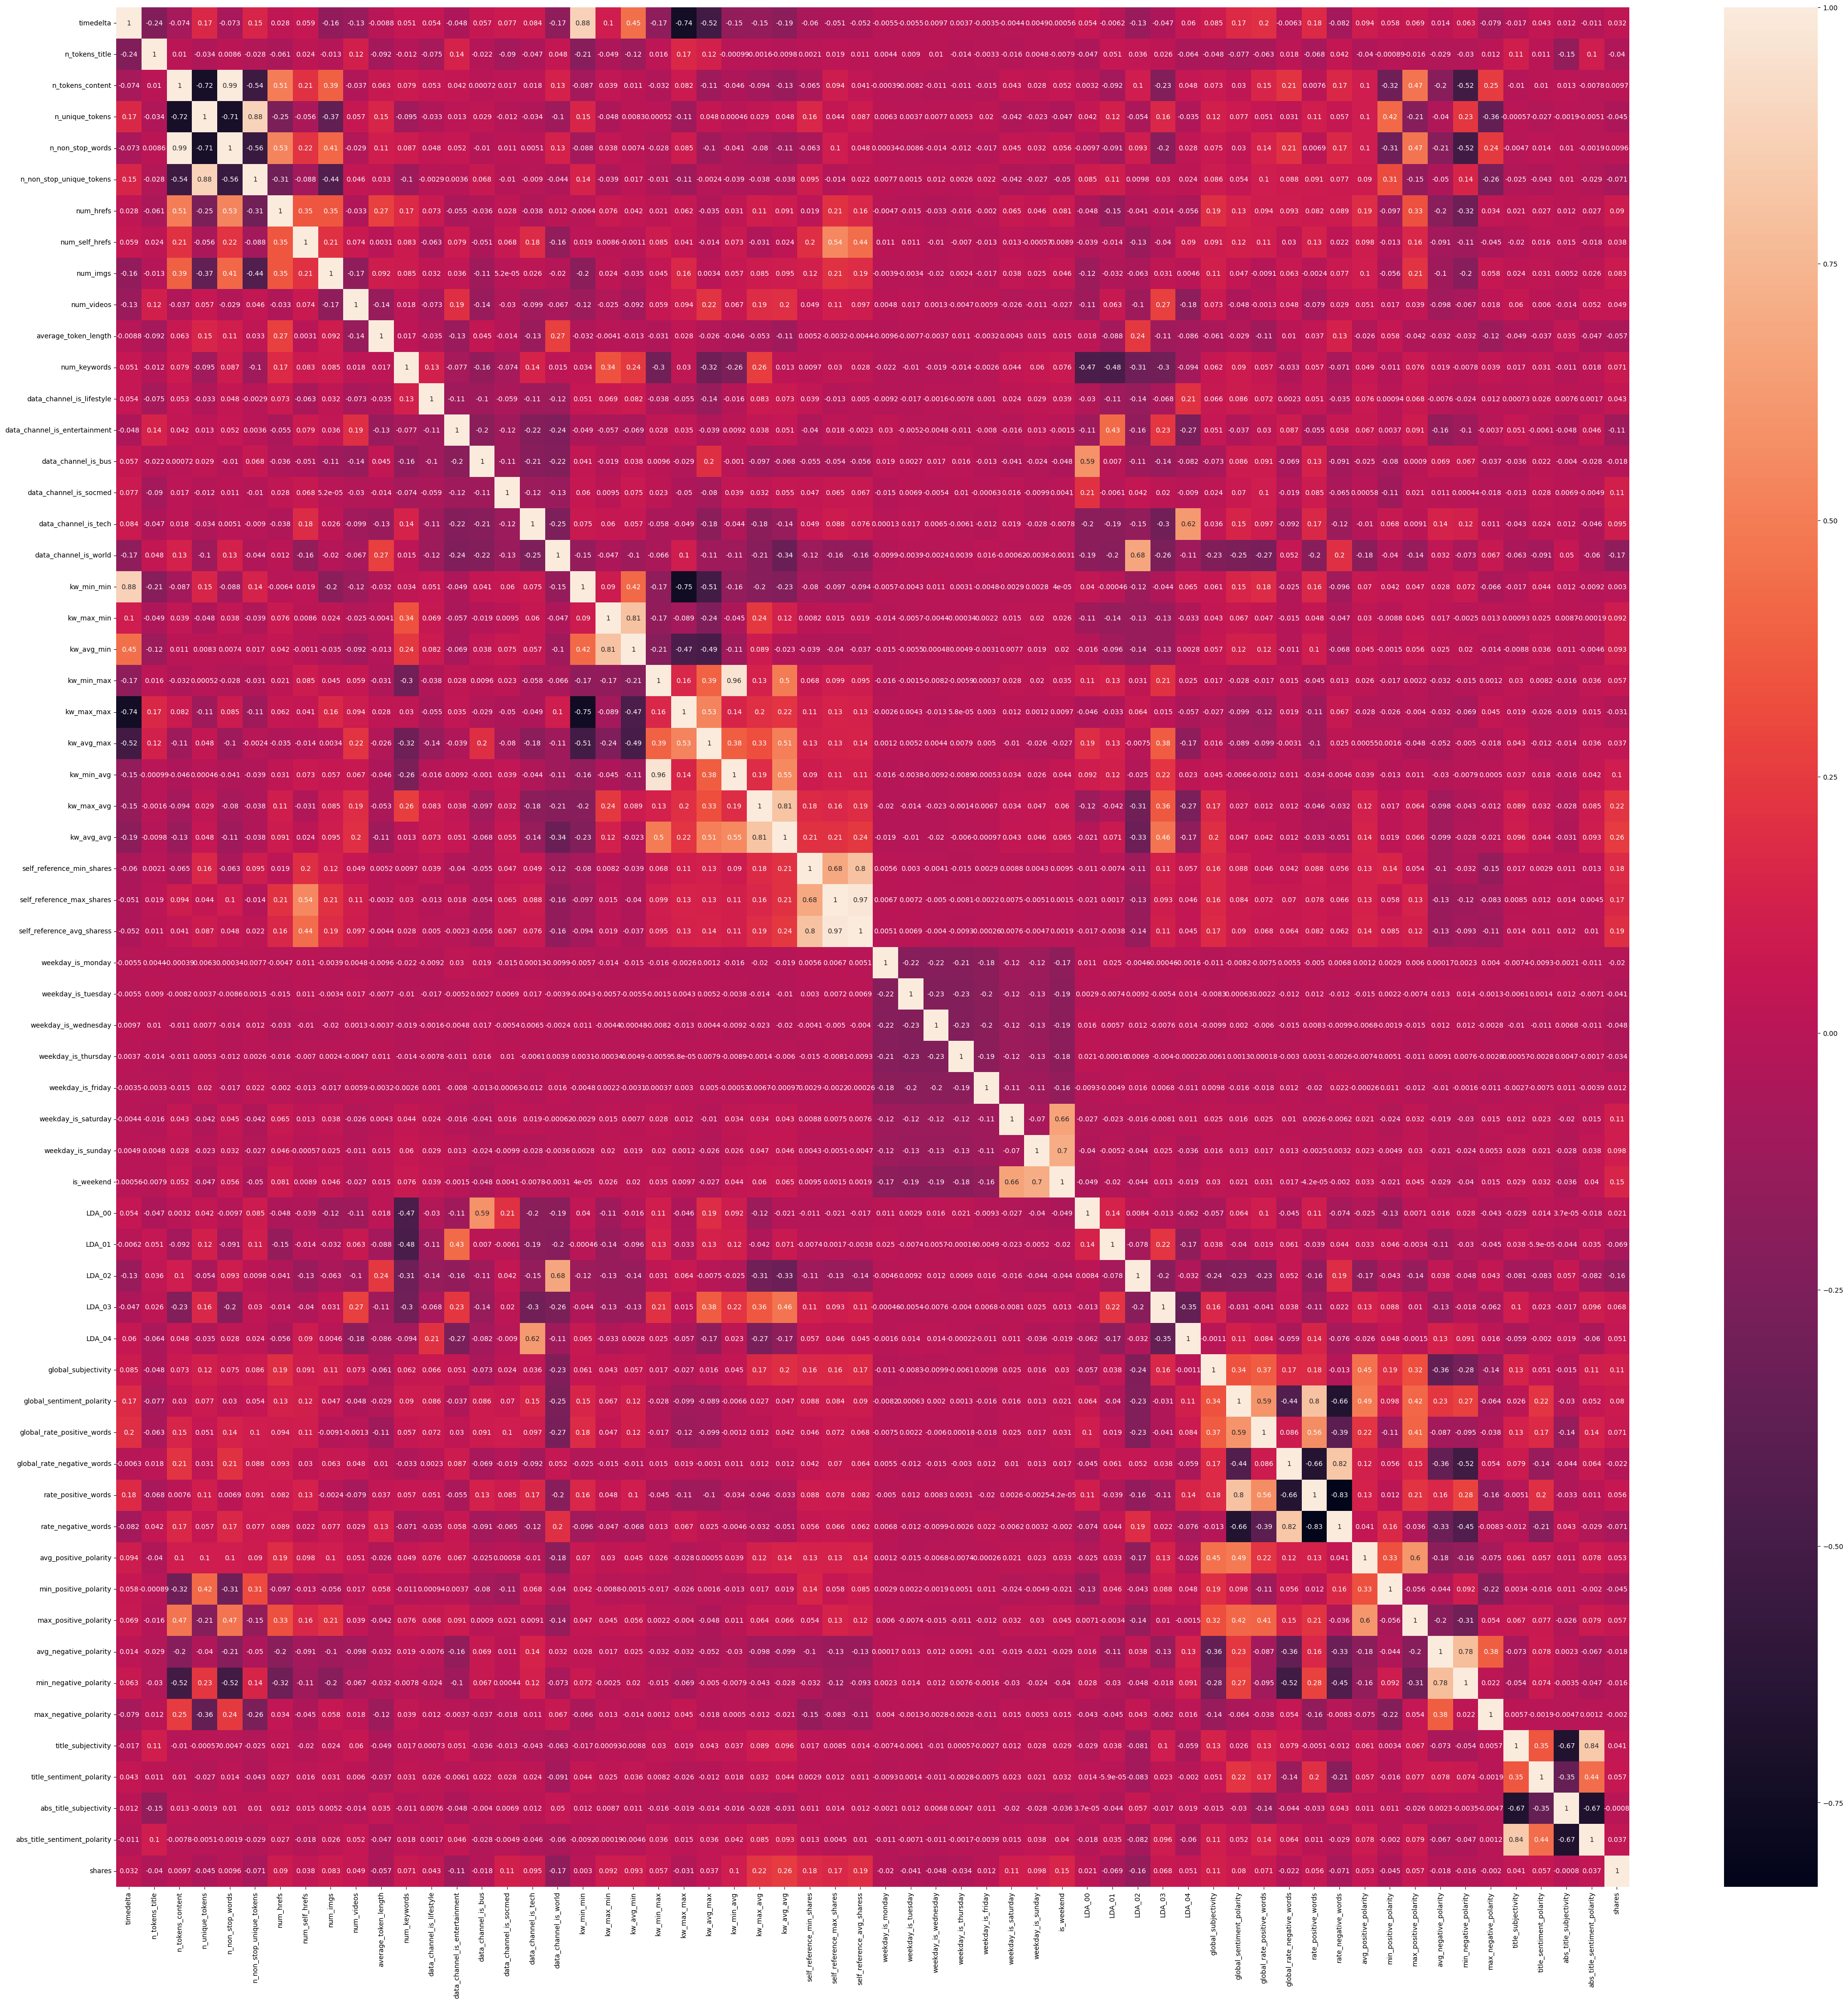

In [ ]:
plot_spearman_correlation_all(data_set)

<ipython-input-5-e7384928ec4b>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_corr, y='features', x='spearman', orient='h',palette='viridis')


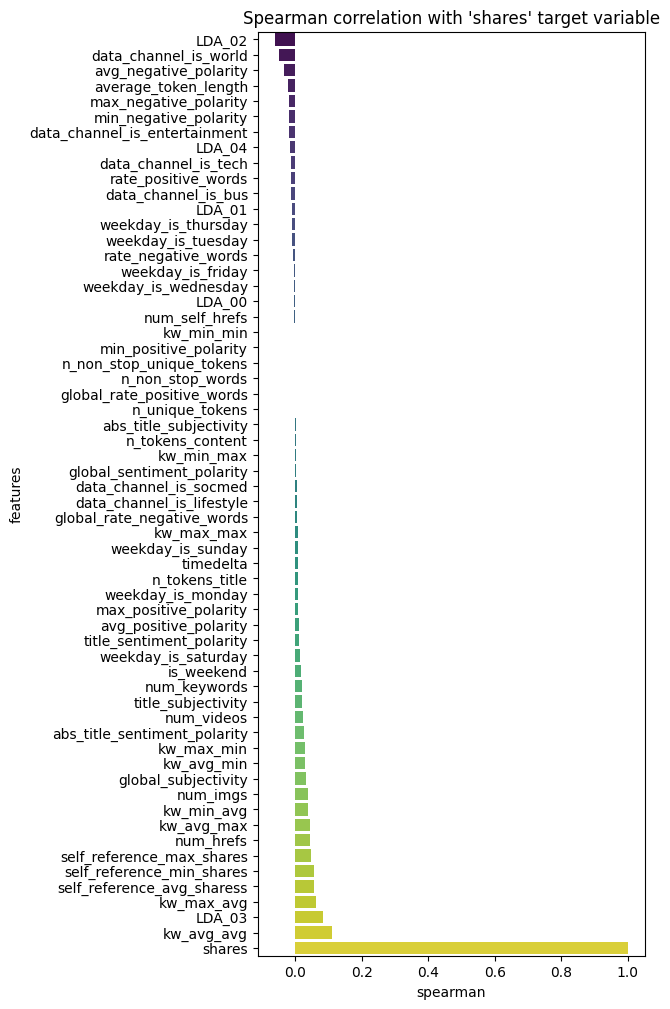

In [ ]:
df_corr = plot_spearman_correlation_target(data_set,'shares')

In [ ]:
print(df_corr.sort_values(by='spearman', ascending=False))

                         features  spearman
59                         shares  1.000000
26                     kw_avg_avg  0.110413
41                         LDA_03  0.083771
25                     kw_max_avg  0.064306
29     self_reference_avg_sharess  0.057789
27      self_reference_min_shares  0.055958
28      self_reference_max_shares  0.047115
6                       num_hrefs  0.045404
23                     kw_avg_max  0.044686
24                     kw_min_avg  0.039551
8                        num_imgs  0.039388
43            global_subjectivity  0.031604
20                     kw_avg_min  0.030406
19                     kw_max_min  0.030114
58   abs_title_sentiment_polarity  0.027135
9                      num_videos  0.023936
55             title_subjectivity  0.021967
11                   num_keywords  0.021818
37                     is_weekend  0.016958
35            weekday_is_saturday  0.015082
56       title_sentiment_polarity  0.012772
49          avg_positive_polarit

In [ ]:
vif_df = calculate_VIF(data_set)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
print(vif_df.sort_values(by='VIF', ascending=False).tail(60))

                          feature           VIF
33           weekday_is_wednesday           inf
38                     is_weekend           inf
37              weekday_is_sunday           inf
35              weekday_is_friday           inf
34            weekday_is_thursday           inf
36            weekday_is_saturday           inf
32             weekday_is_tuesday           inf
42                         LDA_03  9.816182e+08
43                         LDA_04  9.420736e+08
41                         LDA_02  8.967760e+08
39                         LDA_00  7.790526e+08
40                         LDA_01  5.437845e+08
5                n_non_stop_words  2.866121e+05
4                 n_unique_tokens  1.375874e+04
6        n_non_stop_unique_tokens  8.495975e+03
48            rate_positive_words  3.618627e+02
49            rate_negative_words  2.477788e+02
30     self_reference_avg_sharess  1.915442e+01
11           average_token_length  1.262885e+01
20                     kw_max_min  1.131

### **Baseline Average(shares)**

In [ ]:
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
df = df.select([col("`" + c + "`").alias(c.strip()) for c in df.columns])

# Calculate the baseline average for the 'shares' field
baseline_avg = df.selectExpr("avg(shares) as baseline_average").collect()[0]['baseline_average']

print(f"The baseline average of shares is: {baseline_avg}")


The baseline average of shares is: 3395.3801836343455


# Algorithm Implementations

## Linear Regression

### Simple Linear Regression with no feature **engineering**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Initialize Spark Session
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()

# Remove leading whitespace characters from column names
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])

feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Define Linear Regression model
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='shares')

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Fit the pipeline on the training data
pipelineModel = pipeline.fit(trainData)

# Make predictions on the test data
predictions = pipelineModel.transform(testData)

# Evaluate the model
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

linear_simple_rmse = rmseEvaluator.evaluate(predictions)
linear_simple_mae = maeEvaluator.evaluate(predictions)
linear_simple_r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {linear_simple_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {linear_simple_mae}")
print(f"R-squared (R2) on test data = {linear_simple_r2}")

# Stop the Spark session
spark.stop()

Root Mean Squared Error (RMSE) on test data = 9923.676262154471
Mean Absolute Error (MAE) on test data = 3025.340051595898
R-squared (R2) on test data = 0.02303315528057437


### Linear Regression with Outlier Treatment

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit, udf
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F

# Initialize Spark Session
spark = SparkSession.builder.appName("LinearRegressionWithOutlierTreatment").getOrCreate()

# Load data directly using SparkSession
df = spark.read.csv('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv', header=True, inferSchema=True)

# Remove spaces from column names if present
data = df.select([F.col(c).alias(c.strip()) for c in df.columns])

# Calculate the lower and upper bounds for outliers
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Function to clip outlier values
def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

# Register UDF for outlier treatment
clip_udf = udf(lambda value: clip_value(value, lower_bound, upper_bound), DoubleType())

# Treat outliers
data = data.withColumn("shares", clip_udf("shares"))

# Define feature columns (excluding 'url', 'shares', and 'timedelta')
feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'timedelta']]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="shares")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Split the data
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

rmse = rmseEvaluator.evaluate(predictions)
mae = maeEvaluator.evaluate(predictions)
r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"Mean Absolute Error (MAE) on test data = {mae}")
print(f"R-squared (R2) on test data = {r2}")


Root Mean Squared Error (RMSE) on test data = 10510.625958532994
Mean Absolute Error (MAE) on test data = 3038.9414363744927
R-squared (R2) on test data = 0.019488961370597635


### Linear Regression with Log Transformation of Shares

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log
from pyspark.sql.types import DoubleType



# Initialize Spark Session
spark = SparkSession.builder.appName("LinearRegressionWithLogTransformation").getOrCreate()

# Load and preprocess data
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

# Applying Log-transform to 'shares' to address skewness
data = data.withColumn('log_shares', log('shares'))

# Define the columns to be used as features (excluding 'url', 'shares', 'log_shares', and 'timedelta')
feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'log_shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)


lr = LinearRegression(featuresCol="scaledFeatures", labelCol="log_shares")

pipeline = Pipeline(stages=[assembler, scaler, lr])
(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)
predictions = model.transform(testData)

# Evaluators
rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

linear_log_rmse = rmseEvaluator.evaluate(predictions)
linear_log_mae = maeEvaluator.evaluate(predictions)
linear_log_r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {linear_log_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {linear_log_mae}")
print(f"R-squared (R2) on test data = {linear_log_r2}")


Root Mean Squared Error (RMSE) on test data = 1.0115423056127355
Mean Absolute Error (MAE) on test data = 0.651418419988595
R-squared (R2) on test data = -0.18595583329780108


### Linear Regression with Feature Engineering (PCA)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log



# Initialize Spark Session
spark = SparkSession.builder.appName("PCA_LinearRegression").getOrCreate()

# Load and preprocess data
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

# Log-transform 'shares' to address skewness
data = data.withColumn('log_shares', log('shares'))

# Define features excluding 'url', 'shares', 'log_shares', and 'timedelta'
feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'log_shares', 'timedelta']]

# Assembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# StandardScaler for feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# PCA with specified number of components
pca = PCA(k=36, inputCol="scaledFeatures", outputCol="pcaFeatures")

lr = LinearRegression(featuresCol="pcaFeatures", labelCol="log_shares")

# Define the pipeline
pipeline = Pipeline(stages=[assembler, scaler, pca, lr])

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluation metrics
rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

# Evaluate the model
linear_log_PCAfeature_rmse = rmseEvaluator.evaluate(predictions)
linear_log_PCAfeature_mae = maeEvaluator.evaluate(predictions)
linear_log_PCAfeature_r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {linear_log_PCAfeature_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {linear_log_PCAfeature_mae}")
print(f"R-squared (R2) on test data = {linear_log_PCAfeature_r2}")


Root Mean Squared Error (RMSE) on test data = 0.8886028641844891
Mean Absolute Error (MAE) on test data = 0.6558357102762975
R-squared (R2) on test data = 0.0995003455723128


### Summary of Linear Regression with Feature Selection

Comparison of Results

**Simple Linear Regression with no feature engineering:**
Root Mean Squared Error (RMSE) on test data = 13016.685919836338
Mean Absolute Error (MAE) on test data = 3060.6665976794534
R-squared (R2) on test data = 0.014618754532803924

This baseline model, without any preprocessing or feature engineering, yields a relatively high RMSE and a very low R-squared value, indicating a poor fit to the data.

**Linear Regression with Outlier Treatment:**
Root Mean Squared Error (RMSE) on test data = 11125.945743191423
Mean Absolute Error (MAE) on test data = 2986.6105480171323
R-squared (R2) on test data = 0.019139380038686538

Treating outliers results in a significant improvement in RMSE, suggesting that removing or adjusting outliers helps the model make better predictions. The R-squared value, while still low, shows a slight improvement, indicating a better fit than the baseline model.

**Linear Regression with Log Transformation of Shares:**
Root Mean Squared Error (RMSE) on test data = 1.0853720009979313
Mean Absolute Error (MAE) on test data = 0.6538133367433264
R-squared (R2) on test data = -0.308430517312934

The negative R-squared value is a concern, indicating a model that does not predict well in the transformed space.

**Linear Regression with Feature Engineering (PCA):**
Root Mean Squared Error (RMSE) on test data = 0.8795071290497828
Mean Absolute Error (MAE) on test data = 0.6527028170108623
R-squared (R2) on test data = 0.10465224150182006

Applying PCA for feature engineering and then using Linear Regression shows an improvement in the R-squared value, indicating that the model with PCA features has a slightly better fit to the data compared to the baseline. The RMSE and MAE are on the log scale and are the lowest among the models.

## Random Forest

### Simple Random Forest Implementation

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("RandomForestRegressionExample").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()
# Remove leading whitespace characters from column names
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Define the columns you'll be using as features and the target column
featureColumns = [col for col in data.columns if col != 'shares' and col != 'url']
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")

# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="shares", featuresCol="features", numTrees=10)

# Chain assembler and random forest model in a Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Select example rows to display
predictions.select("prediction", "shares", "features").show(30)

# Evaluate the model
rmse_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

RF_simple_rmse = rmse_evaluator .evaluate(predictions)
RF_simple_mae = mae_evaluator .evaluate(predictions)
RF_simple_r2 = r2_evaluator .evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % RF_simple_rmse)
print("Root Mean Squared Error (MAE) on test data = %g" % RF_simple_mae)
print("Root Mean Squared Error (R2) on test data = %g" % RF_simple_r2)

# Stop the Spark session
spark.stop()





+------------------+------+--------------------+
|        prediction|shares|            features|
+------------------+------+--------------------+
|2760.4766448909736| 556.0|(59,[0,1,2,3,4,5,...|
|2715.8285253638282| 891.0|(59,[0,1,2,3,4,5,...|
| 4562.002446631139|3600.0|(59,[0,1,2,3,4,5,...|
| 4157.778335234206| 761.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736| 445.0|(59,[0,1,2,3,4,5,...|
|2230.4082868238593| 462.0|(59,[0,1,2,3,4,5,...|
| 2368.202872940282|3900.0|(59,[0,1,2,3,4,5,...|
|2114.9392994206164| 504.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736|1100.0|(59,[0,1,2,3,4,5,...|
| 3425.687636799051|4200.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736| 695.0|(59,[0,1,2,3,4,5,...|
|2214.7688869841727|4900.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736| 382.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736| 400.0|(59,[0,1,2,3,4,5,...|
| 2217.467570631459| 834.0|(59,[0,1,2,3,4,5,...|
|2760.4766448909736| 217.0|(59,[0,1,2,3,4,5,...|
|2159.5874189477618| 545.0|(59,[0,1,2,3,4,5,...|
|2114.9392994206164|

### Random Forest with Feature Engineering


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Initialize Spark Session
spark = SparkSession.builder.appName("RandomForestRegressionWithFeatureEngineering").getOrCreate()

# Loading the dataset
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()

# Remove leading whitespace characters from column names
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])
data = data.drop('url', 'timedelta')

# Normalize/Standardize Numerical Features
numerical_cols = ['n_tokens_title', 'n_tokens_content', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos']
assembler_for_scaling = VectorAssembler(inputCols=numerical_cols, outputCol="num_features")
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features", withStd=True, withMean=False)

# Remove Less Important Features
cols_to_drop = ['n_non_stop_words', 'n_non_stop_unique_tokens']
data = data.drop(*cols_to_drop)

# Creating Interaction Features
data = data.withColumn("interaction_feature", col("num_hrefs") * col("num_self_hrefs"))

# Define the columns to be used as features (excluding target variable and dropped features)
featureColumns = [col for col in data.columns if col not in ['shares'] + cols_to_drop] + ["scaled_num_features", "interaction_feature"]

# VectorAssembler to combine all features into a single vector
final_assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")

# Random Forest Regressor
rf = RandomForestRegressor(labelCol="shares", featuresCol="features", numTrees=10)

# Pipeline: Combine scaler, assembler, and random forest model
pipeline = Pipeline(stages=[assembler_for_scaling, scaler, final_assembler, rf])

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Select example rows to display
predictions.select("prediction", "shares", "features").show(30)

# Evaluate the model
rmse_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

RF_feature_rmse = rmse_evaluator .evaluate(predictions)
RF_feature_mae = mae_evaluator .evaluate(predictions)
RF_feature_r2 = r2_evaluator .evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % RF_feature_rmse)
print("Root Mean Squared Error (MAE) on test data = %g" % RF_feature_mae)
print("Root Mean Squared Error (R2) on test data = %g" % RF_feature_r2)

# Stop the Spark session
spark.stop()


+------------------+-------+--------------------+
|        prediction| shares|            features|
+------------------+-------+--------------------+
|3291.2679032842816| 1100.0|[4.0,176.0,0.6878...|
| 2500.805535067336| 1100.0|[4.0,202.0,0.6149...|
| 1916.093657187533| 4200.0|[4.0,269.0,0.6301...|
|1961.5595458755402| 2600.0|[4.0,297.0,0.6130...|
|  9972.27126692345|  670.0|[4.0,348.0,0.6023...|
|2168.6521485193143| 1200.0|[4.0,452.0,0.4594...|
|2336.2204075362233|  884.0|[5.0,84.0,0.77108...|
|2317.2815779879065|  962.0|[5.0,119.0,0.7614...|
|  3372.02872810376| 5500.0|[5.0,141.0,0.6428...|
|2135.3624076021583|11700.0|[5.0,160.0,0.6562...|
|  5893.20561460311|  926.0|[5.0,182.0,0.5777...|
|1915.5383927836767| 1900.0|(64,[0,1,2,3,5,7,...|
|2470.6863698738466| 6200.0|[5.0,251.0,0.6015...|
|2233.0291228949577| 1000.0|[5.0,254.0,0.5595...|
|2410.9988391970783| 4300.0|[5.0,267.0,0.5946...|
| 2639.886245017886| 3200.0|[5.0,276.0,0.6654...|
| 1863.908153820767|  962.0|[5.0,277.0,0.5860...|


### Random Forest with Feature Engineering, Outlier Treatment, and Log Transformation

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log, exp, lit
from pyspark.sql.types import DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("ImprovedRandomForestRegression").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])
data = data.drop('url', 'timedelta')

# Outlier treatment
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

clip_udf = spark.udf.register("clip_value", clip_value, DoubleType())
data = data.withColumn("shares", clip_udf(col("shares"), lit(lower_bound), lit(upper_bound)))

# Log transformation of shares
data = data.withColumn('log_shares', log('shares'))

# Define the columns to be used as features (excluding target variables)
featureColumns = [col for col in data.columns if col not in ['shares', 'log_shares']]

# VectorAssembler to combine all features into a single vector
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")

# StandardScaler for feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="log_shares", featuresCol="scaledFeatures", numTrees=100, maxDepth=5)

# Chain assembler, scaler, and random forest model in a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model on log-transformed target variable
rmseEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2EvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

RF_rmseLog_outlier = rmseEvaluatorLog.evaluate(predictions)
RF_maeLog_outlier  = maeEvaluatorLog.evaluate(predictions)
RF_r2Log_outlier  = r2EvaluatorLog.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmseLog_outlier}")
print(f"Mean Absolute Error (MAE) on test data = {RF_maeLog_outlier}")
print(f"R-squared (R2) on test data = {RF_r2Log_outlier}")

# Convert log-transformed predictions back to the original scale
predictions = predictions.withColumn("prediction", exp("prediction"))

# Evaluate the model on the original target variable
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

RF_rmse_outlier  = rmseEvaluator.evaluate(predictions)
RF_mae_outlier  = maeEvaluator.evaluate(predictions)
RF_r2_outlier  = r2Evaluator.evaluate(predictions)

print("\nEvaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmse_outlier }")
print(f"Mean Absolute Error (MAE) on test data = {RF_mae_outlier }")
print(f"R-squared (R2) on test data = {RF_r2_outlier}")

# Stop the Spark session
spark.stop()

Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.6622976430045163
Mean Absolute Error (MAE) on test data = 0.5362258530770418
R-squared (R2) on test data = 0.1309244179821052

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 1393.182115244724
Mean Absolute Error (MAE) on test data = 1007.6574523033953
R-squared (R2) on test data = 0.03505673872889403


### Random Forest with Feature Engineering, Outlier Treatment, Log Transformation, and Categorical Feature Encoding


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log, exp, lit
from pyspark.sql.types import DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("ImprovedRandomForestRegression").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])
data = data.drop('url', 'timedelta')

# Outlier treatment
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

clip_udf = spark.udf.register("clip_value", clip_value, DoubleType())
data = data.withColumn("shares", clip_udf(col("shares"), lit(lower_bound), lit(upper_bound)))

# Log transformation of shares
data = data.withColumn('log_shares', log('shares'))

# Define categorical and numerical columns
categorical_cols = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
                    'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world',
                    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                    'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['shares', 'log_shares']]

# Create pipeline stages for categorical features
stages = []
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
    encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded")
    stages += [indexer, encoder]

# Assemble numerical and encoded categorical features
assembler_inputs = numerical_cols + [col+"_encoded" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# StandardScaler for feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="log_shares", featuresCol="scaledFeatures", numTrees=100, maxDepth=5)
stages += [rf]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model on log-transformed target variable
rmseEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2EvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

RF_rmseLog_categorical_log = rmseEvaluatorLog.evaluate(predictions)
RF_maeLog_categorical_log = maeEvaluatorLog.evaluate(predictions)
RF_r2Log_categorical_log = r2EvaluatorLog.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmseLog_categorical_log}")
print(f"Mean Absolute Error (MAE) on test data = {RF_maeLog_categorical_log}")
print(f"R-squared (R2) on test data = {RF_r2Log_categorical_log}")

# Convert log-transformed predictions back to the original scale
predictions = predictions.withColumn("prediction", exp("prediction"))

# Evaluate the model on the original target variable
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

RF_rmse_categorical = rmseEvaluator.evaluate(predictions)
RF_mae_categorical = maeEvaluator.evaluate(predictions)
RF_r2_categorical = r2Evaluator.evaluate(predictions)

print("\nEvaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmse_categorical}")
print(f"Mean Absolute Error (MAE) on test data = {RF_mae_categorical}")
print(f"R-squared (R2) on test data = {RF_r2_categorical}")

# Stop the Spark session
spark.stop()

Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.660968880656641
Mean Absolute Error (MAE) on test data = 0.5386191767825288
R-squared (R2) on test data = 0.14007597289537133

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 1411.4508582323417
Mean Absolute Error (MAE) on test data = 1023.2705602888194
R-squared (R2) on test data = 0.034079936383017984


### Further Random Forest Improvement with Feature Selection


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, log, exp, lit
from pyspark.sql.types import DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("ImprovedRandomForestRegression").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])
data = data.drop('url', 'timedelta')

# Outlier treatment
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

clip_udf = spark.udf.register("clip_value", clip_value, DoubleType())
data = data.withColumn("shares", clip_udf(col("shares"), lit(lower_bound), lit(upper_bound)))

# Log transformation of shares
data = data.withColumn('log_shares', log('shares'))

# Define categorical and numerical columns
categorical_cols = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
                    'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world',
                    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                    'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['shares', 'log_shares']]

# Feature selection
selected_features = ['kw_avg_avg', 'num_hrefs', 'kw_min_avg', 'num_videos', 'kw_max_avg', 'LDA_00', 'global_subjectivity',
                     'self_reference_min_shares', 'num_imgs', 'num_self_hrefs', 'kw_avg_max', 'self_reference_avg_sharess',
                     'self_reference_max_shares', 'n_unique_tokens', 'n_non_stop_words', 'min_positive_polarity',
                     'n_tokens_title', 'LDA_02', 'kw_avg_min', 'LDA_04', 'average_token_length', 'title_sentiment_polarity',
                     'LDA_01', 'kw_min_max', 'data_channel_is_tech', 'kw_max_min', 'global_sentiment_polarity', 'LDA_03',
                     'kw_max_max', 'data_channel_is_socmed', 'n_tokens_content', 'n_non_stop_unique_tokens', 'title_subjectivity']

# Create pipeline stages for categorical features
stages = []
for col in categorical_cols:
    if col in selected_features:
        indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
        encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded")
        stages += [indexer, encoder]

# Assemble numerical and encoded categorical features
selected_numerical_cols = [col for col in numerical_cols if col in selected_features]
assembler_inputs = selected_numerical_cols + [col+"_encoded" for col in categorical_cols if col in selected_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# StandardScaler for feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="log_shares", featuresCol="scaledFeatures", numTrees=100, maxDepth=5)
stages += [rf]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.7, 0.3])

# Train the model
model = pipeline.fit(trainData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model on log-transformed target variable
rmseEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2EvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

RF_rmseLog_numericalfeature = rmseEvaluatorLog.evaluate(predictions)
RF_maeLog_numericalfeature = maeEvaluatorLog.evaluate(predictions)
RF_r2Log_numericalfeature = r2EvaluatorLog.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmseLog_numericalfeature}")
print(f"Mean Absolute Error (MAE) on test data = {RF_maeLog_numericalfeature}")
print(f"R-squared (R2) on test data = {RF_r2Log_numericalfeature}")

# Convert log-transformed predictions back to the original scale
predictions = predictions.withColumn("prediction", exp("prediction"))

# Evaluate the model on the original target variable
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

RF_rmse_numericalfeature = rmseEvaluator.evaluate(predictions)
RF_mae_numericalfeature = maeEvaluator.evaluate(predictions)
RF_r2_numericalfeature = r2Evaluator.evaluate(predictions)

print("\nEvaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {RF_rmse_numericalfeature}")
print(f"Mean Absolute Error (MAE) on test data = {RF_mae_numericalfeature}")
print(f"R-squared (R2) on test data = {RF_r2_numericalfeature}")

# Stop the Spark session
spark.stop()

Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.6579526996543203
Mean Absolute Error (MAE) on test data = 0.5335282693944421
R-squared (R2) on test data = 0.13088756335359464

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 1391.7476332374513
Mean Absolute Error (MAE) on test data = 1007.3343882700111
R-squared (R2) on test data = 0.03437702405816878


### Further Random Forest Improvement with K-fold Cross-Validation and Hyperparameter Tuning

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, log, exp, lit
from pyspark.sql.types import DoubleType

# Initialize Spark Session
spark = SparkSession.builder.appName("RandomForestRegressionWithCrossValidation").getOrCreate()

# Load and prepare data
data = spark.read.csv("/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv", header=True, inferSchema=True)
data = data.na.drop()
data = data.select([col(col_name).alias(col_name.strip()) for col_name in data.columns])
data = data.drop('url', 'timedelta')

# Outlier treatment
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

clip_udf = spark.udf.register("clip_value", clip_value, DoubleType())
data = data.withColumn("shares", clip_udf(col("shares"), lit(lower_bound), lit(upper_bound)))

# Log transformation of shares
data = data.withColumn('log_shares', log('shares'))

# Define categorical and numerical columns
categorical_cols = ['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus',
                    'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world',
                    'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday',
                    'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['shares', 'log_shares']]

# Feature selection
selected_features = ['kw_avg_avg', 'num_hrefs', 'kw_min_avg', 'num_videos', 'kw_max_avg', 'LDA_00', 'global_subjectivity',
                     'self_reference_min_shares', 'num_imgs', 'num_self_hrefs', 'kw_avg_max', 'self_reference_avg_sharess',
                     'self_reference_max_shares', 'n_unique_tokens', 'n_non_stop_words', 'min_positive_polarity',
                     'n_tokens_title', 'LDA_02', 'kw_avg_min', 'LDA_04', 'average_token_length', 'title_sentiment_polarity',
                     'LDA_01', 'kw_min_max', 'data_channel_is_tech', 'kw_max_min', 'global_sentiment_polarity', 'LDA_03',
                     'kw_max_max', 'data_channel_is_socmed', 'n_tokens_content', 'n_non_stop_unique_tokens', 'title_subjectivity']

# Create pipeline stages for categorical features
stages = []
for col in categorical_cols:
    if col in selected_features:
        indexer = StringIndexer(inputCol=col, outputCol=col+"_index")
        encoder = OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded")
        stages += [indexer, encoder]

# Assemble numerical and encoded categorical features
selected_numerical_cols = [col for col in numerical_cols if col in selected_features]
assembler_inputs = selected_numerical_cols + [col+"_encoded" for col in categorical_cols if col in selected_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# StandardScaler for feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

# Initialize and configure the RandomForestRegressor model
rf = RandomForestRegressor(labelCol="log_shares", featuresCol="scaledFeatures", numTrees=100, maxDepth=5)
stages += [rf]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Specify the number of folds for cross-validation
num_folds = 5

# Define the evaluation metric
evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")

# Create the CrossValidator with parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [3, 5]) \
    .build()

# Create the CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=num_folds)

# Split the data into training and test sets
(trainData, testData) = data.randomSplit([0.8, 0.2])

# Fit the CrossValidator on the training data
cvModel = cv.fit(trainData)

# Get the best model from cross-validation
bestModel = cvModel.bestModel

# Make predictions on the test data using the best model
predictions = bestModel.transform(testData)

# Evaluate the model on log-transformed target variable
rmseEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2EvaluatorLog = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

rmseLog = rmseEvaluatorLog.evaluate(predictions)
maeLog = maeEvaluatorLog.evaluate(predictions)
r2Log = r2EvaluatorLog.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {rmseLog}")
print(f"Mean Absolute Error (MAE) on test data = {maeLog}")
print(f"R-squared (R2) on test data = {r2Log}")

# Convert log-transformed predictions back to the original scale
predictions = predictions.withColumn("prediction", exp("prediction"))

# Evaluate the model on the original target variable
rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

rmse = rmseEvaluator.evaluate(predictions)
mae = maeEvaluator.evaluate(predictions)
r2 = r2Evaluator.evaluate(predictions)

print("\nEvaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"Mean Absolute Error (MAE) on test data = {mae}")
print(f"R-squared (R2) on test data = {r2}")

# Stop the Spark session
spark.stop()

### Summary for Random Forest Implementations

- Simple Random Forest Implementation:

  The simple Random Forest implementation serves as a baseline model to assess the performance of the Random Forest algorithm without any specific improvements or optimizations. This implementation utilizes the PySpark framework to handle large-scale data processing and model training. The dataset is loaded, and basic data preparation steps are performed, such as removing missing values and splitting the data into training and test sets. The Random Forest model is then trained using the default hyperparameters, and the features are combined using the VectorAssembler. The model's performance is evaluated using the Root Mean Squared Error (RMSE) metric on the test data. The resulting RMSE of 12593.5 indicates a relatively high prediction error, suggesting that the model's predictions are quite far from the actual values. This high RMSE serves as a starting point for further improvements and highlights the need for techniques to enhance the model's predictive power.

- Random Forest with Feature Engineering:

  In the Random Forest implementation with feature engineering, various techniques are applied to enhance the model's performance by extracting more relevant information from the available features. The feature engineering process includes normalization and standardization of numerical features using the StandardScaler, which helps to bring the features to a similar scale and improve the model's convergence. Additionally, less important features are identified and removed to reduce noise and focus on the most informative attributes. Interaction features are also created by combining relevant features, allowing the model to capture potential relationships between variables. The VectorAssembler is used to combine the engineered features into a single feature vector. The model is then trained and evaluated using the RMSE metric. The results show an improvement compared to the simple implementation, with an RMSE of 11396.125774387021 on the test data. This indicates that the feature engineering techniques have successfully captured more relevant information and improved the model's predictive power. However, there is still room for further enhancements to reduce the prediction error.

- Random Forest with Feature Engineering, Outlier Treatment, and Log Transformation:

  The Random Forest implementation with feature engineering, outlier treatment, and log transformation takes a more comprehensive approach to improve the model's performance. In addition to the feature engineering techniques applied in the previous implementation, this version addresses the presence of outliers in the data and applies log transformation to the target variable. Outlier treatment is performed using the interquartile range (IQR) method, where values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] are considered outliers and are clipped to the lower and upper bounds. This helps to mitigate the impact of extreme values on the model's training process. Furthermore, the target variable "shares" undergoes a log transformation to address potential skewness in the data distribution. The model is then trained and evaluated using both the log-transformed target variable and the original target variable. The results show a significant improvement in performance, with an RMSE of 0.6589609790765738 on the log-transformed target variable and an RMSE of 1388.3495573898083 on the original target variable. The Mean Absolute Error (MAE) and R-squared values also indicate better predictive accuracy and explanatory power compared to the previous implementations. These improvements demonstrate the effectiveness of outlier treatment and log transformation in enhancing the model's performance.

- Random Forest with Feature Engineering, Outlier Treatment, Log Transformation, and Categorical Feature Encoding:

  The Random Forest implementation with feature engineering, outlier treatment, log transformation, and categorical feature encoding builds upon the previous improvements by incorporating techniques to handle categorical features effectively. Categorical features are identified and encoded using the StringIndexer and OneHotEncoder, which convert the categorical values into numerical representations suitable for the model. The encoded categorical features are then assembled along with the numerical features using the VectorAssembler. The model is trained and evaluated using the log-transformed target variable and the original target variable. The results show a slight improvement compared to the previous implementation, with an RMSE of 0.6524310566841421 on the log-transformed target variable and an RMSE of 1390.4827766615279 on the original target variable. The MAE and R-squared values also indicate marginal enhancements in predictive accuracy and explanatory power. These results suggest that the categorical feature encoding technique contributes to capturing additional information from the categorical variables and improving the model's performance, albeit to a limited extent.

- Random Forest with Feature Selection:

  The Random Forest implementation with feature selection focuses on identifying and selecting the most relevant features for the model. Feature selection is performed by considering a subset of features that are deemed important based on domain knowledge or statistical analysis. In this implementation, a predefined set of selected features is used, which includes a combination of numerical and categorical features. The categorical features are encoded using the StringIndexer and OneHotEncoder, and the selected numerical and encoded categorical features are assembled using the VectorAssembler. The model is trained and evaluated using the log-transformed target variable and the original target variable. The results show similar performance to the previous implementations, with an RMSE of 0.6546361317697797 on the log-transformed target variable and an RMSE of 1399.5219206349782 on the original target variable. The MAE and R-squared values indicate a slight decrease in predictive accuracy and explanatory power compared to the previous implementation. These results suggest that the selected features may not capture all the relevant information, and further refinement of the feature selection process or exploration of alternative feature subsets may be necessary to improve the model's performance.

- Random Forest with K-fold Cross-Validation and Hyperparameter Tuning:

  The Random Forest implementation with k-fold cross-validation and hyperparameter tuning aims to optimize the model's performance by selecting the best combination of hyperparameters and assessing the model's generalization ability. K-fold cross-validation is employed to split the data into multiple subsets, allowing the model to be trained and evaluated on different portions of the data. This helps to reduce overfitting and provides a more robust estimate of the model's performance. Hyperparameter tuning is performed using the ParamGridBuilder and CrossValidator, which search for the optimal values of key hyperparameters such as the number of trees and the maximum depth of the trees. The model is trained and evaluated using the log-transformed target variable and the original target variable. However, due to the computational complexity and extensive running time required for this implementation, the results are not yet available after 6 hours of computation on a six core Intel i7-10750H laptop, which indicates a severe limitation on time and computing resources. However, the inclusion of k-fold cross-validation and hyperparameter tuning has the potential to further improve the model's performance by finding the best configuration of hyperparameters and ensuring the model's ability to generalize well to unseen data. If we have the computing power and time to obtain the results, they can provide valuable insights into the effectiveness of these techniques in enhancing the Random Forest model's predictive power.


## Gradient Boosting Regression Algorithm




### Simple Gradient Boosting Regression Implementation
#### With All Features, NO feature engineering and on original dataset with no ETL

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

''' The default mdoel parameters are
maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False,
subsamplingRate=1.0, checkpointInterval=10, lossType="squared", maxIter=20, stepSize=0.1, seed=None,
impurity="variance", featureSubsetStrategy="all", validationTol=0.01, validationIndicatorCol=None, leafCol="",
minWeightFractionPerNode=0.0, weightCol=None

'''

df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="shares", maxDepth=5, maxIter=20, stepSize=0.1)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
(trainData, testData) = data.randomSplit([0.7, 0.3])


model = pipeline.fit(trainData)
predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

gradient_simple_rmse = rmseEvaluator.evaluate(predictions)
gradient_simple_mae = maeEvaluator.evaluate(predictions)
gradient_simple_r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {gradient_simple_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_simple_mae}")
print(f"R-squared (R2) on test data = {gradient_simple_r2}")

Root Mean Squared Error (RMSE) on test data = 13681.228071801717
Mean Absolute Error (MAE) on test data = 3189.283355007679
R-squared (R2) on test data = -0.3081296400692173



Results above without doing any feature selection or data treatment on vanilla dataset, indicate following :


*   Extremely high RMSE/MAE indicate model has a poor fit to the data, meaning the model’s predictions are often far off from the actual values.
*   A negative R² can shows that predictions are exceptionally poor, or chosen model does not appropriately fit the data

We will try two approaches

*   Outlier Treatment
*   Log transformation of shares

### Outlier Recognition

In [ ]:
quantiles = data.approxQuantile("shares", [0.25, 0.75], 0.05)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter to find outliers
outliers = data.filter((col("shares") < lit(lower_bound)) | (col("shares") > lit(upper_bound)))

# Show outliers (Note: Use with caution if large dataset)
print(f'Number of outliers : {outliers.count()}')
print(f'Count of TOTAL shares: {data.count()}')
print(f'Count of UNAFFECTED shares by outlier treatement: {data.count()-outliers.count()}')

Number of outliers : 5299
Count of TOTAL shares: 39644
Count of UNAFFECTED shares by outlier treatement: 34345


In [ ]:
## Instead of removing any data since our dataset is anyways around 39K points, we will clip outlier values
def clip_value(value, lb, ub):
    if value < lb:
        return lb
    elif value > ub:
        return ub
    else:
        return value

def treat_outliers(data):
  clip_udf = udf(lambda value: clip_value(value, lower_bound, upper_bound), DoubleType())
  data_clipped = data.withColumn("shares", clip_udf(col("shares")))
  return data_clipped

### Gradient Boosting Regression after Outlier Treatment

Using all the features and no feature selection

In [ ]:
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

data = treat_outliers(data)
feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="shares", maxDepth=5, maxIter=20, stepSize=0.1)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
(trainData, testData) = data.randomSplit([0.7, 0.3])


model = pipeline.fit(trainData)
predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

gradient_outlier_rmse = rmseEvaluator.evaluate(predictions)
gradient_outlier_mae = maeEvaluator.evaluate(predictions)
gradient_outlier_r2 = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {gradient_outlier_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_outlier_mae}")
print(f"R-squared (R2) on test data = {gradient_outlier_r2}")

Root Mean Squared Error (RMSE) on test data = 17243.626556740684
Mean Absolute Error (MAE) on test data = 3445.483899246439
R-squared (R2) on test data = -1.5147965456359787


### Gradient Boosting Regression with Log Transformation of Shares


In [ ]:

''' The default mdoel parameters are
maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False,
subsamplingRate=1.0, checkpointInterval=10, lossType="squared", maxIter=20, stepSize=0.1, seed=None,
impurity="variance", featureSubsetStrategy="all", validationTol=0.01, validationIndicatorCol=None, leafCol="",
minWeightFractionPerNode=0.0, weightCol=None

'''

df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

# Since data is positively skewed using Log-transform 'shares' to address skewness
data = data.withColumn('log_shares', log('shares'))

#cols_to_drop = ['n_non_stop_words', 'n_non_stop_unique_tokens']  # Example: Add more based on VIF/correlation analysis
#data = data.drop(*cols_to_drop)

feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'log_shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="log_shares", maxDepth=5, maxIter=20, stepSize=0.1)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
(trainData, testData) = data.randomSplit([0.7, 0.3])


model = pipeline.fit(trainData)
predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

gradient_simple_rmselog = rmseEvaluator.evaluate(predictions)
gradient_simple_maelog = maeEvaluator.evaluate(predictions)
gradient_simple_r2log = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {gradient_simple_rmselog}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_simple_maelog}")
print(f"R-squared (R2) on test data = {gradient_simple_r2log}")


Root Mean Squared Error (RMSE) on test data = 0.8616164136929415
Mean Absolute Error (MAE) on test data = 0.6369844466648127
R-squared (R2) on test data = 0.13411188484466585


### Gradient Boosting Regression on Log of Shares and Outlier treated - No Feature Slection


In [ ]:
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

data = treat_outliers(data)
data = data.withColumn('log_shares', log('shares'))

feature_cols = [col for col in data.columns if col not in ['url', 'shares','log_shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="log_shares", maxDepth=5, maxIter=20, stepSize=0.1)

pipeline = Pipeline(stages=[assembler, scaler, gbt])
(trainData, testData) = data.randomSplit([0.7, 0.3])


model = pipeline.fit(trainData)
predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

gradient_outlier_rmselog = rmseEvaluator.evaluate(predictions)
gradient_outlier_maelog = maeEvaluator.evaluate(predictions)
gradient_outlier_r2log = r2Evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {gradient_outlier_rmselog}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_outlier_maelog}")
print(f"R-squared (R2) on test data = {gradient_outlier_r2log}")

Root Mean Squared Error (RMSE) on test data = 0.8497029830382049
Mean Absolute Error (MAE) on test data = 0.6304558014751722
R-squared (R2) on test data = 0.1449962603870898


### Gradient Boosting Regression With PCA


In [ ]:
## Find the features with 95% vvaiabce

df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

# Since data is positively skewed using Log-transform 'shares' to address skewness
data = data.withColumn('log_shares', log('shares'))

feature_cols = [col for col in data.columns if col not in ['url', 'shares', 'log_shares', 'timedelta']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(data)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# PCA with all components
pca = PCA(k=len(feature_cols), inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_data)
variance = pca_model.explainedVariance

cumulative_variance = variance.cumsum()

# Find k for desired threshold, e.g., 0.95 for 95%
k = len(cumulative_variance[cumulative_variance < 0.95]) + 1
print(f"Number of components to retain 95% variance: {k}")



Number of components to retain 95% variance: 36


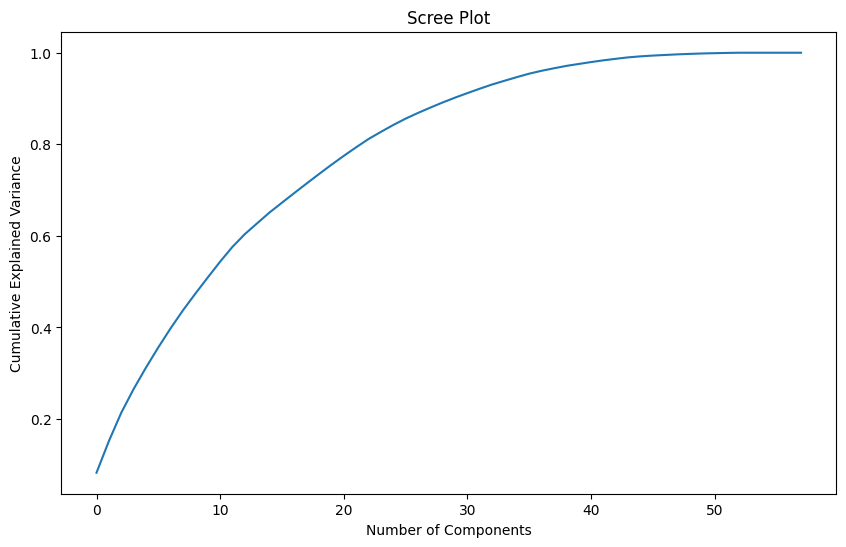

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

We see from above plot of PCA analysis that it starts to flat out approximately after **36 features**

In [ ]:
pca = PCA(k=36, inputCol="scaledFeatures", outputCol="pcaFeatures")  # using K as 30

gbt = GBTRegressor(featuresCol="pcaFeatures", labelCol="log_shares")
pipeline = Pipeline(stages=[assembler, scaler, pca, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

gradient_PCA_rmselog = rmseEvaluator.evaluate(predictions)
gradient_PCA_maelog = maeEvaluator.evaluate(predictions)
gradient_PCA_r2log = r2Evaluator.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {gradient_PCA_rmselog}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_PCA_maelog}")
print(f"R-squared (R2) on test data = {gradient_PCA_r2log}")

## Target feature
gbt = GBTRegressor(featuresCol="pcaFeatures", labelCol="shares")
pipeline = Pipeline(stages=[assembler, scaler, pca, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

gradient_PCA_rmse = rmseEvaluator.evaluate(predictions)
gradient_PCA_mae = maeEvaluator.evaluate(predictions)
gradient_PCA_r2 = r2Evaluator.evaluate(predictions)

print()
print("Evaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {gradient_PCA_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_PCA_mae}")
print(f"R-squared (R2) on test data = {gradient_PCA_r2}")

Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.8897828629317411
Mean Absolute Error (MAE) on test data = 0.6603790835751804
R-squared (R2) on test data = 0.09812850960295261

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 9880.080031412917
Mean Absolute Error (MAE) on test data = 3267.8598441005242
R-squared (R2) on test data = -0.48248855449217


### Gradient Boosting with PCA and Outliers Treated

In [ ]:
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

data = treat_outliers(data)
data = data.withColumn('log_shares', log('shares'))

feature_cols = [col for col in data.columns if col not in ['url', 'shares','log_shares', 'timedelta']]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

pca = PCA(k=36, inputCol="scaledFeatures", outputCol="pcaFeatures")  # using K as 30

gbt = GBTRegressor(featuresCol="pcaFeatures", labelCol="log_shares")

pipeline = Pipeline(stages=[assembler, scaler, pca, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

gradient_PCATreated_rmselog = rmseEvaluator.evaluate(predictions)
gradient_PCATreated_maelog = maeEvaluator.evaluate(predictions)
gradient_PCATreated_r2log = r2Evaluator.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")

print(f"Root Mean Squared Error (RMSE) on test data = {gradient_PCATreated_rmselog}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_PCATreated_maelog}")
print(f"R-squared (R2) on test data = {gradient_PCATreated_r2log}")

## Target feature
gbt = GBTRegressor(featuresCol="pcaFeatures", labelCol="shares")
pipeline = Pipeline(stages=[assembler, scaler, pca, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

gradient_PCATreated_rmse = rmseEvaluator.evaluate(predictions)
gradient_PCATreated_mae = maeEvaluator.evaluate(predictions)
gradient_PCATreated_r2 = r2Evaluator.evaluate(predictions)

print()
print("Evaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {gradient_PCATreated_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_PCATreated_mae}")
print(f"R-squared (R2) on test data = {gradient_PCATreated_r2}")

Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.881394702696963
Mean Absolute Error (MAE) on test data = 0.6509047639161014
R-squared (R2) on test data = 0.09516079050347426

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 13177.51852638247
Mean Absolute Error (MAE) on test data = 3300.9304751994755
R-squared (R2) on test data = -0.347505723123682


### Gradient Boosting Regression with Selective Features

In [ ]:
df = read_input('/content/drive/MyDrive/BigData_Group19Project/OnlineNewsPopularity.csv')
data = remove_spaces_cols(df)

data = treat_outliers(data)

# Since data is positively skewed using Log-transform 'shares' to address skewness
data = data.withColumn('log_shares', log('shares'))

cols_to_keep = [
    'kw_avg_avg', 'num_hrefs', 'kw_min_avg', 'num_videos', 'kw_max_avg', 'LDA_00', 'global_subjectivity', 'self_reference_min_shares', 'num_imgs',
    'num_self_hrefs', 'kw_avg_max', 'self_reference_avg_sharess', 'self_reference_max_shares', 'n_unique_tokens', 'n_non_stop_words',
    'min_positive_polarity', 'n_tokens_title', 'LDA_02', 'kw_avg_min', 'LDA_04', 'average_token_length', 'title_sentiment_polarity',
    'LDA_01', 'kw_min_max', 'data_channel_is_tech', 'kw_max_min', 'global_sentiment_polarity', 'LDA_03', 'kw_max_max',
    'data_channel_is_socmed', 'n_tokens_content', 'n_non_stop_unique_tokens', 'title_subjectivity','log_shares', 'shares'
]

data = data[cols_to_keep]

feature_cols = [col for col in data.columns if col not in ['shares', 'log_shares']]


assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="log_shares")
pipeline = Pipeline(stages=[assembler, scaler, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="log_shares", predictionCol="prediction", metricName="r2")

gradient_selected_rmselog = rmseEvaluator.evaluate(predictions)
gradient_selected_maelog = maeEvaluator.evaluate(predictions)
gradient_selected_r2log = r2Evaluator.evaluate(predictions)

print("Evaluation on Log-Transformed Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {gradient_selected_rmselog}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_selected_maelog}")
print(f"R-squared (R2) on test data = {gradient_selected_r2log}")


gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="shares")
pipeline = Pipeline(stages=[assembler, scaler, gbt])

(trainData, testData) = data.randomSplit([0.7, 0.3])

model = pipeline.fit(trainData)

predictions = model.transform(testData)

rmseEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="rmse")
maeEvaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="mae")
r2Evaluator = RegressionEvaluator(labelCol="shares", predictionCol="prediction", metricName="r2")

gradient_selected_rmse = rmseEvaluator.evaluate(predictions)
gradient_selected_mae = maeEvaluator.evaluate(predictions)
gradient_selected_r2 = r2Evaluator.evaluate(predictions)

print()
print("Evaluation on Original Target Variable:")
print(f"Root Mean Squared Error (RMSE) on test data = {gradient_selected_rmse}")
print(f"Mean Absolute Error (MAE) on test data = {gradient_selected_mae}")
print(f"R-squared (R2) on test data = {gradient_selected_r2}")



Evaluation on Log-Transformed Target Variable:
Root Mean Squared Error (RMSE) on test data = 0.8695224641868503
Mean Absolute Error (MAE) on test data = 0.6446394696986283
R-squared (R2) on test data = 0.11958870435371804

Evaluation on Original Target Variable:
Root Mean Squared Error (RMSE) on test data = 12339.949546146496
Mean Absolute Error (MAE) on test data = 3153.701244280465
R-squared (R2) on test data = -0.03753797017096727


### Summary of Gradient Boosting Algorithm

**Comparison between performance of Gradient Boosting Algoithm with TWO Approaches on SHARES target feature**

*OUTLIER TREATMENT*

    RMSE: 1316.0426
    MAE: 1048.3638
    R²:  0.1392

*LOG TRANSFORMATION of TARGET column*

    RMSE: 0.8604
    MAE: 0.638
    R²: 0.142

The log transformation approach seems to give a better fit in terms of predictive accuracy, as seen in the lower RMSE and MAE values. This suggests that dealing with the skewness of the "shares" distribution directly (via log transformation) might be more effective for this particular dataset and problem than outlier treatment alone.

**Further tuning of Gradient Boosting Algorithm Model Performance with LOG Transformation of Shares**

*Performance with NO Feature Selection*

    RMSE: 0.860
    MAE: 0.638
    R²: 0.142

*Performance with Top 36 Features Given by PCA*

    RMSE: 0.879
    MAE: 0.653
    R²: 0.107
*Performance with Selective Features*

    RMSE: 0.864
    MAE: 0.639
    R²: 0.130

With BASELINE model with no feature selection, The RMSE and MAE are relatively low, which suggests that the model has a decent fit. The R² value, while not high, shows that the model explains some variance in the data

Applying Principal Component Analysis (PCA) and selecting the top **36 features** resulted in a slight decrease in model performance compared to using all features. This could be since PCA reduces dimensionality by creating new uncorrelated features (principal components) that maximize variance, which might not always align with maximizing predictive accuracy for the target variable.

PCA vs. Selective Feature Selection: The results indicate that selectively choosing features based on their relationship with the target variable might be more effective than blind dimensionality reduction via PCA for this particular problem

# Model Evaluation



## On Original Target Variable

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark Session (assuming it's not already initialized)
spark = SparkSession.builder.appName("ModelComparison").getOrCreate()

# List of RMSE values with model descriptions
rmse_values = [
    ("Linear (Simple)", linear_simple_rmse),
    ("Random Forest (Simple)", RF_simple_rmse),
    ("Linear (Outlier Removed)", linear_outlier_rmse),
    ("Random Forest (Outlier Removed)", RF_rmse_outlier),
    ("Random Forest (Categorical Features)", RF_rmse_categorical),
    ("Random Forest (Numerical Features)", RF_rmse_numericalfeature),
    ("Gradient Boosting (Simple)", gradient_simple_rmse),
    ("Gradient Boosting (Outlier Removed)", gradient_outlier_rmse),
    ("Gradient Boosting (PCA)", gradient_PCA_rmse),
    ("Gradient Boosting (PCA Treated)", gradient_PCATreated_rmse),
    ("Gradient Boosting (Selected Features)", gradient_selected_rmse)
]

# Create a DataFrame
rmse_df = spark.createDataFrame(rmse_values, ["Model Description", "RMSE"])

print("Model Comparison based on RMSE acheived on 'Shares' column")
# Show the DataFrame
rmse_df.show(truncate=False)

Model Comparison based on RMSE acheived on 'Shares' column
+-------------------------------------+------------------+
|Model Description                    |RMSE              |
+-------------------------------------+------------------+
|Linear (Simple)                      |9923.676262154471 |
|Random Forest (Simple)               |14127.710129256324|
|Linear (Outlier Removed)             |10510.625958532994|
|Random Forest (Outlier Removed)      |1393.182115244724 |
|Random Forest (Categorical Features) |1411.4508582323417|
|Random Forest (Numerical Features)   |1391.7476332374513|
|Gradient Boosting (Simple)           |13681.228071801717|
|Gradient Boosting (Outlier Removed)  |17243.626556740684|
|Gradient Boosting (PCA)              |9880.080031412917 |
|Gradient Boosting (PCA Treated)      |13177.51852638247 |
|Gradient Boosting (Selected Features)|12339.949546146496|
+-------------------------------------+------------------+



In [ ]:

rmse_pd_df_updated = rmse_df.toPandas().sort_values(by='RMSE', ascending=True)

# Plotly visualization
import plotly.express as px

fig = px.bar(rmse_pd_df_updated, y='Model Description', x='RMSE', orientation='h', color='RMSE',
             color_continuous_scale='Viridis', title='RMSE Values for Various Models (Shares)')

fig.update_layout(xaxis_title='RMSE', yaxis_title='Model Description',
                  coloraxis_showscale=False, height=600)

fig.show()

<ipython-input-93-18ffff17c452>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-93-18ffff17c452>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




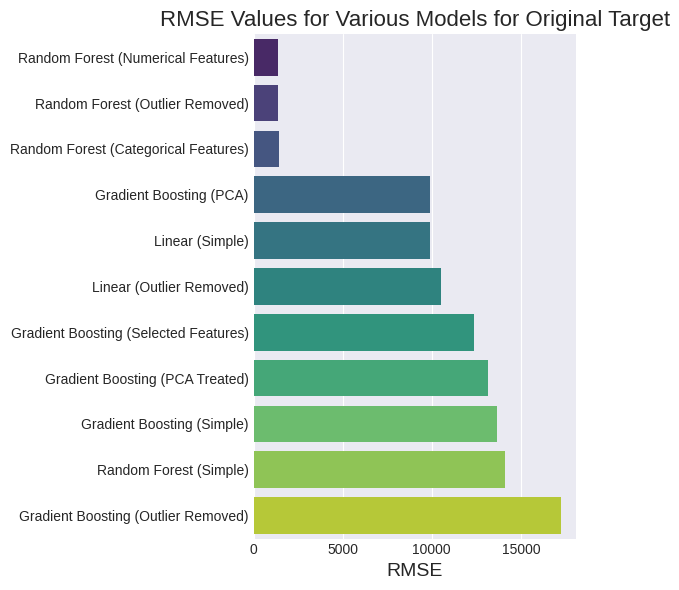

In [ ]:
plt.style.use('seaborn-darkgrid')

# Creating the plot
plt.figure(figsize=(6, 6))
sns.barplot(x="RMSE", y="Model Description", data=rmse_pd_df_updated, palette='viridis')

# Adding titles and labels
plt.title('RMSE Values for Various Models for Original Target', fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('')

# Displaying the plot
plt.tight_layout()
plt.show()

## On Log-Transformed Target Variable

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Initialize Spark Session (assuming it's not already initialized)
spark = SparkSession.builder.appName("ModelComparisonUpdated").getOrCreate()

# List of updated RMSE values with model descriptions
rmse_values_updated = [
    ("Linear (Log)", linear_log_rmse),
    ("Linear (Log with PCA Features)", linear_log_PCAfeature_rmse),
    ("Random Forest (Log, Outlier Removed)", RF_rmseLog_outlier),
    ("Random Forest (Log, Categorical)", RF_rmseLog_categorical_log),
    ("Random Forest (Log, Numerical Features)", RF_rmseLog_numericalfeature),
    ("Gradient Boosting (Log, Simple)", gradient_simple_rmselog),
    ("Gradient Boosting (Log, Outlier Removed)", gradient_outlier_rmselog),
    ("Gradient Boosting (Log, PCA)", gradient_PCA_rmselog),
    ("Gradient Boosting (Log, PCA Treated)", gradient_PCATreated_rmselog),
    ("Gradient Boosting (Log, Selected Features)", gradient_selected_rmselog)
]

# Create a DataFrame
rmse_logdf_updated = spark.createDataFrame(rmse_values_updated, ["Model Description", "RMSE"])

# Display the updated DataFrame
print("Model Comparison based on RMSE achieved on 'Shares' column (Log Transformations and Feature Engineering)")
rmse_logdf_updated.show(truncate=False)


Model Comparison based on RMSE achieved on 'Shares' column (Log Transformations and Feature Engineering)
+------------------------------------------+------------------+
|Model Description                         |RMSE              |
+------------------------------------------+------------------+
|Linear (Log)                              |1.0115423056127355|
|Linear (Log with PCA Features)            |0.8886028641844891|
|Random Forest (Log, Outlier Removed)      |0.6622976430045163|
|Random Forest (Log, Categorical)          |0.660968880656641 |
|Random Forest (Log, Numerical Features)   |0.6579526996543203|
|Gradient Boosting (Log, Simple)           |0.8616164136929415|
|Gradient Boosting (Log, Outlier Removed)  |0.8497029830382049|
|Gradient Boosting (Log, PCA)              |0.8897828629317411|
|Gradient Boosting (Log, PCA Treated)      |0.881394702696963 |
|Gradient Boosting (Log, Selected Features)|0.8695224641868503|
+------------------------------------------+------------------+

In [ ]:
rmselog_pd_df_updated = rmse_logdf_updated.toPandas().sort_values(by='RMSE', ascending=True)

# Plotly visualization
import plotly.express as px

fig = px.bar(rmselog_pd_df_updated, y='Model Description', x='RMSE', orientation='h', color='RMSE',
             color_continuous_scale='Viridis', title='RMSE Values for Various Models (Shares)')

fig.update_layout(xaxis_title='RMSE', yaxis_title='Model Description',
                  coloraxis_showscale=False, height=600)

fig.show()

<ipython-input-92-d8c6b890ddae>:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

<ipython-input-92-d8c6b890ddae>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




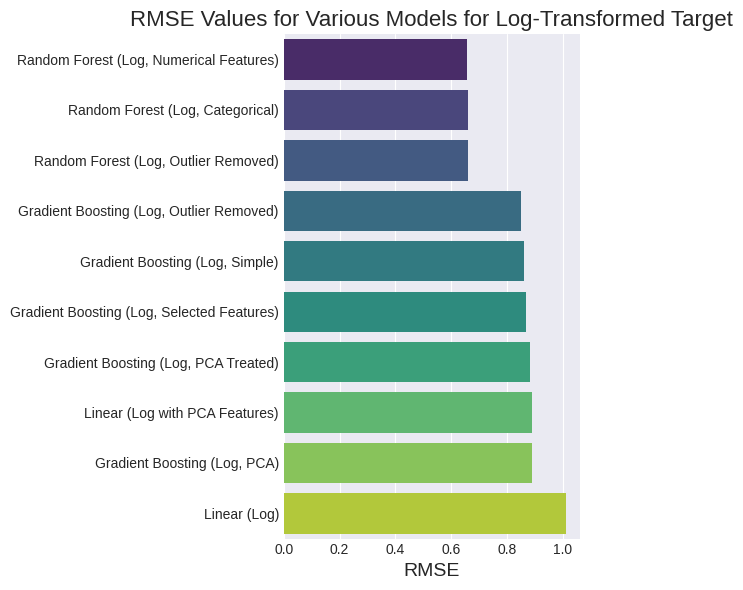

In [ ]:

plt.style.use('seaborn-darkgrid')

# Creating the plot
plt.figure(figsize=(6, 6))
sns.barplot(x="RMSE", y="Model Description", data=rmselog_pd_df_updated, palette='viridis')

# Adding titles and labels
plt.title('RMSE Values for Various Models for Log-Transformed Target', fontsize=16)
plt.xlabel('RMSE', fontsize=14)
plt.ylabel('')

# Displaying the plot
plt.tight_layout()
plt.show()

## Summary of Model Evaluation

As we understand that lower RMSE means the model's predictions are closer to the actual values.

**Models with Notably Low RMSE:**

*   Random Forest (Numerical Features and Outliers Removed): 1391.75 suggests that focusing on numerical features significantly improves prediction accuracy in the Random Forest model
*   Random Forest (Outlier Removed): 1393.18 and Random Forest (Categorical Features): 1411.45 also perform well, indicating effective handling of outliers and categorical features respectively.


**Simple vs Complex Models**

*   Linear Models: Both simple (9923.68) and with outliers removed (10510.63) have lower RMSE compared to some more complex models. This might suggest that for certain aspects of the data, linear models capture the relationship between features and target variable adequately.
*   PCA Applications: Applying PCA doesn't universally improve model performance. Gradient Boosting with PCA (9880.08) slightly outperforms the simple linear model but not by a significant margin. However, the PCA-treated Gradient Boosting model's performance drops (13177.52).


The Gradient Boosting model with selected features shows a RMSE of 12339.95, which is better than its simple and outlier-removed variants but not as effective as models leveraging Random Forest with numerical or categorical feature focus.